In [651]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
# plt.style.use('ggplot')
import seaborn as sns
from enum import Enum
import matplotlib.colors as mcolors
import colorsys
import os

In [652]:
# results = pd.read_csv("../test_results/hyper_sdqlpy_dense_tuning_test_results.csv") 
results = pd.read_csv("../test_results/hyper_sdqlpy_pandas_tpch_direct_optimisations_test_results.csv") 

In [653]:
print(f"Overall Results: {len(results)}")

# Filter for Correct == True and Executed == Yes
results = results[(results.Correct == True) & (results.Executed == "Yes")]
print(f"Correct Results: {len(results)}")

Overall Results: 176
Correct Results: 176


In [654]:
def g_mean(x):
    a = np.log(x)
    return np.exp(a.mean())

def pre_process(df):
    # Sort Query Name column to in-order
    def extract_number(name):
        if isinstance(name, int):
            return name
        else:
            return int(name.split(" ")[1])

    df['Query Number'] = df.apply(lambda row : extract_number(row['Query Number']), axis = 1)
    df = df.sort_values(['Query Number'])

    # Fix the runs column
    def fix_runs(runs):
        new_runs = list(str(str(runs)[1:-1]).split(","))
        for i in range(0, len(new_runs)):
            new_runs[i] = float(new_runs[i].strip())
        return new_runs

    df['Runs'] = df.apply(lambda row : fix_runs(row['Runs']), axis = 1)

    def ignore_first_gmean(runs):
        return g_mean(runs[1:])
    
    def ignore_first_mean(runs):
        return sum(runs[1:]) / len(runs[1:])

    df["Mean"] = df.apply(lambda row : ignore_first_mean(row['Runs']), axis = 1)
    df["Query Type"] = df["Query Name"]
    df = df[["Query Type", "Query Number", "Mean", "Runs"]]
    
    return df

results = pre_process(results)

In [655]:
def make_overall_table(df):
    overall = df.groupby("Query Type").agg(
        overall_mean_runtime=("Mean", g_mean)
    )
    overall = overall.sort_values(by="overall_mean_runtime")
    overall = overall.rename(columns={"overall_mean_runtime": "Overall Mean Runtime (s)"})
    return overall

In [656]:
overall = make_overall_table(results)
overall.head(15)

,Overall Mean Runtime (s)
Query Type,
Hyper DB,0.153907
O1 SDQLpy,0.155856
O4 SDQLpy,0.220752
O2 SDQLpy,0.274375
O3 SDQLpy,0.274924
Naive SDQLpy,0.278308
Pandas Converted + O4 (Hyper DB),0.426387
Pandas Converted (Hyper DB),0.427010


In [657]:
def get_querytype_mean_dict(query_type):
    query_numbers = list(results[results['Query Type'] == query_type].to_dict()['Query Number'].values())
    query_means = list(results[results['Query Type'] == query_type].to_dict()['Mean'].values())

    return dict(zip(query_numbers, query_means))

def percentage_difference(num1, num2):
    return 100 * (abs(num1 - num2) / ((num1 + num2) / 2))

def runtime_reduction(old, new):
    return ((old - new) / old) * 100

all_type = "O2 SDQLpy"
prev_type = "Naive SDQLpy"

all_runtimes = get_querytype_mean_dict(all_type)
prev_runtimes = get_querytype_mean_dict(prev_type)

slower = 0
faster = 0

threshold = 5
for query, all_runtime in all_runtimes.items():
    prev_runtime = prev_runtimes[query]
    perc_diff = round(percentage_difference(all_runtime, prev_runtime), 5)
    if prev_runtime < all_runtime and perc_diff >= threshold:
        print(f"For Query {query}, '{all_type}' was more than {threshold}% slower than '{prev_type}'.")
        print(f"\t'{all_type}': {all_runtime}")
        print(f"\t'{prev_type}': {prev_runtime}")
        print(f"\tPercentage difference: {perc_diff}%")
        slower += 1
    elif prev_runtime > all_runtime and perc_diff >= threshold:
        print(f"For Query {query}, '{all_type}' was more than {threshold}% faster than '{prev_type}'.")
        print(f"\t'{all_type}': {all_runtime}")
        print(f"\t'{prev_type}': {prev_runtime}")
        print(f"\tPercentage difference: {perc_diff}%")
        faster += 1
        
print(f"{slower} Queries were Slower after Optimising")
print(f"{faster} Queries were Faster after Optimising")

# round(percentage_difference(0.274375, 0.278308), 5)

For Query 2, 'O2 SDQLpy' was more than 5% faster than 'Naive SDQLpy'.
	'O2 SDQLpy': 0.09449753761291504
	'Naive SDQLpy': 0.1019127368927002
	Percentage difference: 7.55072%
For Query 12, 'O2 SDQLpy' was more than 5% faster than 'Naive SDQLpy'.
	'O2 SDQLpy': 0.2999711990356445
	'Naive SDQLpy': 0.3201327323913574
	Percentage difference: 6.50263%
For Query 17, 'O2 SDQLpy' was more than 5% faster than 'Naive SDQLpy'.
	'O2 SDQLpy': 0.1484351634979248
	'Naive SDQLpy': 0.15941958427429198
	Percentage difference: 7.13611%
For Query 18, 'O2 SDQLpy' was more than 5% slower than 'Naive SDQLpy'.
	'O2 SDQLpy': 0.219075345993042
	'Naive SDQLpy': 0.202647066116333
	Percentage difference: 7.79104%
For Query 22, 'O2 SDQLpy' was more than 5% faster than 'Naive SDQLpy'.
	'O2 SDQLpy': 0.028642892837524414
	'Naive SDQLpy': 0.03185625076293945
	Percentage difference: 10.62282%
1 Queries were Slower after Optimising
4 Queries were Faster after Optimising


In [658]:
def runtime_reduction(old, new):
    return ((old - new) / old) * 100

runtime_reduction(0.08513712882995605, 0.07212376594543457)

15.285179408050048

In [659]:
runtime_reduction(0.427010, 0.426387)

0.1458982225240591

In [660]:
# IQR
naive_results = results[results["Query Type"] == 'Naive SDQLpy']
Q1 = naive_results['Mean'].quantile(0.25)
Q3 = naive_results['Mean'].quantile(0.75)
print(f"Naive IQR: {Q3 - Q1}")

o4_results = results[results["Query Type"] == 'O4 SDQLpy']
Q1 = o4_results['Mean'].quantile(0.25)
Q3 = o4_results['Mean'].quantile(0.75)
print(f"O4 IQR: {Q3 - Q1}")

Naive IQR: 0.6796446800231933
O4 IQR: 0.4523171782493591


## Dense and Update Sum plots

In [661]:
def make_compare_graph(df, order, color, filename):
    # plot with seaborn barplot
    sns.set(rc={'figure.figsize':(10,6)})
    background_color = '#f1f4f5'
    # sns.set(rc={'axes.facecolor':background_color})
    plt.rcParams['patch.linewidth'] = 1.0
    plt.rcParams['patch.edgecolor'] = 'k'
    
    plt.rc('axes', labelsize=16)    # fontsize of the x and y labels

    ax = sns.barplot(data=df, x='Query Number', y='Mean', hue='Query Type',
                     palette=color, hue_order=order)

    # ax.set_yscale("log")
    ax.set(xlabel='Query', ylabel='Mean Runtime (ms)')

    # Make axes weightier
    plt.setp(ax.spines.values(), linewidth=2)
    
    for spine in ax.spines.values():
        spine.set_edgecolor('k')

    #set parameters for tick labels
    plt.tick_params(axis='x', which='major')
    plt.tick_params(axis='y', which='major', direction="out", colors="k", left=True, labelsize=14)
    
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.10),
              ncol=4, fancybox=False, shadow=False, fontsize=16)

    ax.spines[['right', 'top']].set_visible(False)
    
    ax.patch.set_alpha(0.0)
    
    plt.tight_layout()

    if filename != None:
        plt.savefig(filename, bbox_inches="tight")
    plt.show()

In [662]:
def get_queries_that_were_significant(old, new):
    all_runtimes = get_querytype_mean_dict(new)
    prev_runtimes = get_querytype_mean_dict(old)

    queries_that_were_significant = []

    threshold = 5
    for query, all_runtime in all_runtimes.items():
        prev_runtime = prev_runtimes[query]
        perc_diff = round(percentage_difference(all_runtime, prev_runtime), 5)
        if prev_runtime < all_runtime and perc_diff >= threshold:
            print(f"For Query {query}, '{all_type}' was more than {threshold}% slower than '{prev_type}'.")
            print(f"\t'{all_type}': {all_runtime}")
            print(f"\t'{prev_type}': {prev_runtime}")
            print(f"\tPercentage difference: {perc_diff}%")
            queries_that_were_significant.append(query)
        elif prev_runtime > all_runtime and perc_diff >= threshold:
            print(f"For Query {query}, '{all_type}' was more than {threshold}% faster than '{prev_type}'.")
            print(f"\t'{all_type}': {all_runtime}")
            print(f"\t'{prev_type}': {prev_runtime}")
            print(f"\tPercentage difference: {perc_diff}%")
            queries_that_were_significant.append(query)
            
    return queries_that_were_significant

For Query 2, 'O2 SDQLpy' was more than 5% faster than 'Naive SDQLpy'.
	'O2 SDQLpy': 0.09449753761291504
	'Naive SDQLpy': 0.1019127368927002
	Percentage difference: 7.55072%
For Query 12, 'O2 SDQLpy' was more than 5% faster than 'Naive SDQLpy'.
	'O2 SDQLpy': 0.2999711990356445
	'Naive SDQLpy': 0.3201327323913574
	Percentage difference: 6.50263%
For Query 17, 'O2 SDQLpy' was more than 5% faster than 'Naive SDQLpy'.
	'O2 SDQLpy': 0.1484351634979248
	'Naive SDQLpy': 0.15941958427429198
	Percentage difference: 7.13611%
For Query 18, 'O2 SDQLpy' was more than 5% slower than 'Naive SDQLpy'.
	'O2 SDQLpy': 0.219075345993042
	'Naive SDQLpy': 0.202647066116333
	Percentage difference: 7.79104%
For Query 22, 'O2 SDQLpy' was more than 5% faster than 'Naive SDQLpy'.
	'O2 SDQLpy': 0.028642892837524414
	'Naive SDQLpy': 0.03185625076293945
	Percentage difference: 10.62282%


/tmp/ipykernel_88726/3659330785.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_df['Query Type'] = current_df['Query Type'].replace(
/tmp/ipykernel_88726/3659330785.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_df['Mean'] = current_df['Mean'].apply(lambda x : x * 1000)


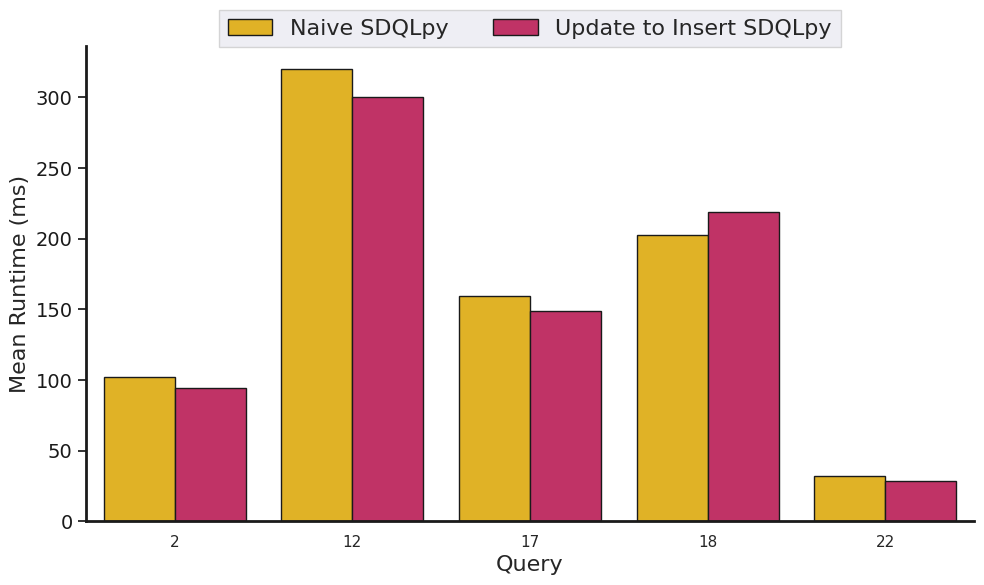

In [663]:
queries_that_were_significant = get_queries_that_were_significant("Naive SDQLpy", "O2 SDQLpy")
current_df = results[results["Query Number"].isin(queries_that_were_significant)]
current_df['Query Type'] = current_df['Query Type'].replace(
        {
            'Naive SDQLpy': 'Naive SDQLpy', 
            'O2 SDQLpy': 'Update to Insert SDQLpy'
        }
    )

current_df['Mean'] = current_df['Mean'].apply(lambda x : x * 1000)
pg_order = ['Naive SDQLpy', 'Update to Insert SDQLpy']
pg_color = ['#FFC107','#D81B60']
pg_filename = f"../analysis_results/y2_report/O2_barplot.pdf"

make_compare_graph(current_df, pg_order, pg_color, pg_filename)

In [664]:
runtime_reduction(0.03185625076293945, 0.028642892837524414)

10.087056224310473

For Query 2, 'O2 SDQLpy' was more than 5% faster than 'Naive SDQLpy'.
	'O2 SDQLpy': 0.09145183563232422
	'Naive SDQLpy': 0.1019127368927002
	Percentage difference: 10.81987%
For Query 6, 'O2 SDQLpy' was more than 5% faster than 'Naive SDQLpy'.
	'O2 SDQLpy': 0.055913543701171874
	'Naive SDQLpy': 0.06105551719665527
	Percentage difference: 8.79202%
For Query 7, 'O2 SDQLpy' was more than 5% faster than 'Naive SDQLpy'.
	'O2 SDQLpy': 0.5397974014282226
	'Naive SDQLpy': 0.5746184349060058
	Percentage difference: 6.2492%
For Query 8, 'O2 SDQLpy' was more than 5% faster than 'Naive SDQLpy'.
	'O2 SDQLpy': 0.13888206481933593
	'Naive SDQLpy': 0.15051369667053222
	Percentage difference: 8.03856%
For Query 9, 'O2 SDQLpy' was more than 5% faster than 'Naive SDQLpy'.
	'O2 SDQLpy': 1.1082254886627196
	'Naive SDQLpy': 1.198706817626953
	Percentage difference: 7.8443%
For Query 10, 'O2 SDQLpy' was more than 5% faster than 'Naive SDQLpy'.
	'O2 SDQLpy': 1.20065279006958
	'Naive SDQLpy': 1.335137224197387

/tmp/ipykernel_88726/566442872.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_df['Query Type'] = current_df['Query Type'].replace(
/tmp/ipykernel_88726/566442872.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_df['Mean'] = current_df['Mean'].apply(lambda x : x * 1000)


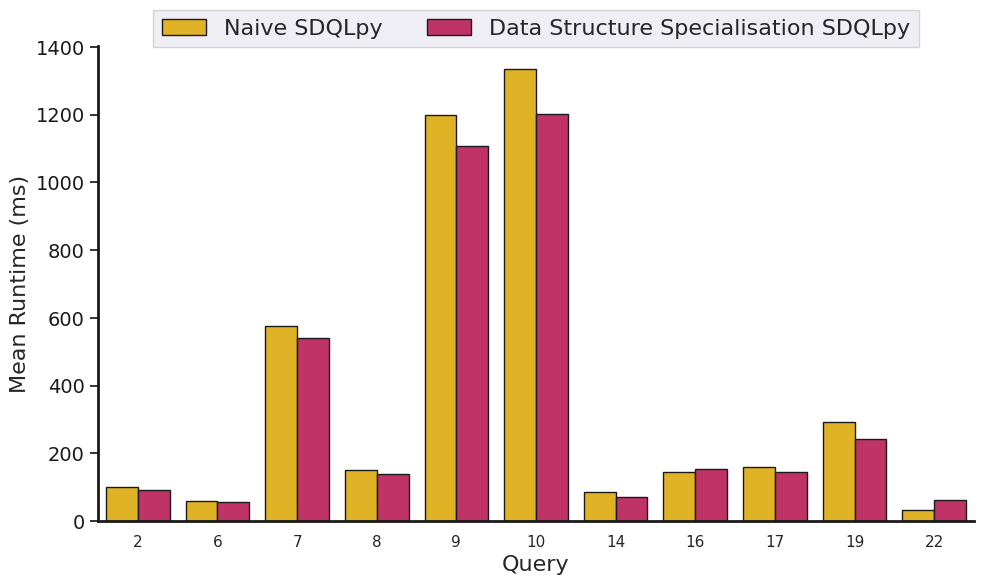

In [665]:
queries_that_were_significant = get_queries_that_were_significant("Naive SDQLpy", "O3 SDQLpy")
current_df = results[results["Query Number"].isin(queries_that_were_significant)]
current_df['Query Type'] = current_df['Query Type'].replace(
        {
            'Naive SDQLpy': 'Naive SDQLpy', 
            'O3 SDQLpy': 'Data Structure Specialisation SDQLpy'
        }
    )
current_df['Mean'] = current_df['Mean'].apply(lambda x : x * 1000)
pg_order = ["Naive SDQLpy", "Data Structure Specialisation SDQLpy"]
pg_color = ['#FFC107','#D81B60']
pg_filename = f"../analysis_results/y2_report/O3_barplot.pdf"

make_compare_graph(current_df, pg_order, pg_color, pg_filename)

## Boxplots

In [666]:
results['Query Type'] = results['Query Type'].replace(
    {
        'Pandas Converted (Hyper DB)': 'Pandas',
        'Pandas Converted + O4 (Hyper DB)': 'O4 Pandas'
    }
)

In [667]:
results

,Query Type,Query Number,Mean,Runs
0,Hyper DB,1,0.129322,"[0.13045930862426758, 0.1293809413909912, 0.12..."
1,Naive SDQLpy,1,1.295751,"[1.366431713104248, 1.3349874019622803, 1.2851..."
2,O1 SDQLpy,1,0.073416,"[0.07568359375, 0.07184267044067383, 0.0736100..."
3,O2 SDQLpy,1,1.343711,"[1.3827297687530518, 1.3863816261291504, 1.312..."
4,O3 SDQLpy,1,1.333620,"[1.4018220901489258, 1.3590068817138672, 1.331..."
...,...,...,...,...
170,O1 SDQLpy,22,0.027338,"[0.03550386428833008, 0.02771592140197754, 0.0..."
171,O2 SDQLpy,22,0.028643,"[0.039954423904418945, 0.028383493423461914, 0..."
172,O3 SDQLpy,22,0.061738,"[0.07193589210510254, 0.0604250431060791, 0.06..."
173,O4 SDQLpy,22,0.029004,"[0.03833436965942383, 0.02956557273864746, 0.0..."


In [668]:
# Compare 
compare_groups = [
    ("O4_graph.pdf", ["Naive SDQLpy", "O4 SDQLpy", "Pandas", "O4 Pandas"]),
    ("O1_graph.pdf", ["Naive SDQLpy", "O1 SDQLpy"]),
]

In [669]:
def make_boxplot_graph(original_df, data_labels, filename = None):
    new_df = original_df[original_df["Query Type"].isin(data_labels)]
    # Convert to ms
    new_df['Mean'] = new_df['Mean'].apply(lambda x : x * 1000)
    
    new_df['Query Type'] = new_df['Query Type'].replace(
        {
            'O4 SDQLpy': 'Early Projection\nSDQLpy', 
            'O4 Pandas': 'Early Projection\nPandas', 
            'O1 SDQLpy': 'Fusion\nSDQLpy', 
            'O2 SDQLpy': 'Update Sum\nSDQLpy', 
            'O3 SDQLpy': 'Dense\nSDQLpy', 
            'Naive SDQLpy': 'Naive\nSDQLpy', 
        }
    )

    with sns.axes_style("ticks"):
        sns.set_theme(rc={'figure.figsize':(10,5)})

        ax = sns.boxplot(data=new_df, y="Query Type", x="Mean", color="#D9D9D9", linecolor="k", linewidth=1)
        
        plt.rc('axes', labelsize=24)    # fontsize of the x and y labels
        
        ax.set_ylabel("")
        ax.set_xlabel("Runtime (ms)", fontsize=20)
        
        plt.tick_params(axis='x', which='major', labelsize=16)
        plt.tick_params(axis='y', which='major', direction="out", colors="k", left=True, labelsize=18)
    
        # Make axes weightier
        plt.setp(ax.spines.values(), linewidth=1)
        
        for spine in ax.spines.values():
            spine.set_edgecolor('k')
            
        ax.spines[['right', 'top']].set_visible(False)
        
        plt.tight_layout()
    
        if filename != None:
            os.makedirs(os.path.dirname(filename), exist_ok=True)  
            plt.savefig(filename, bbox_inches="tight", transparent=True)
        
        plt.show()

/tmp/ipykernel_88726/2059523897.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Mean'] = new_df['Mean'].apply(lambda x : x * 1000)
/tmp/ipykernel_88726/2059523897.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Query Type'] = new_df['Query Type'].replace(


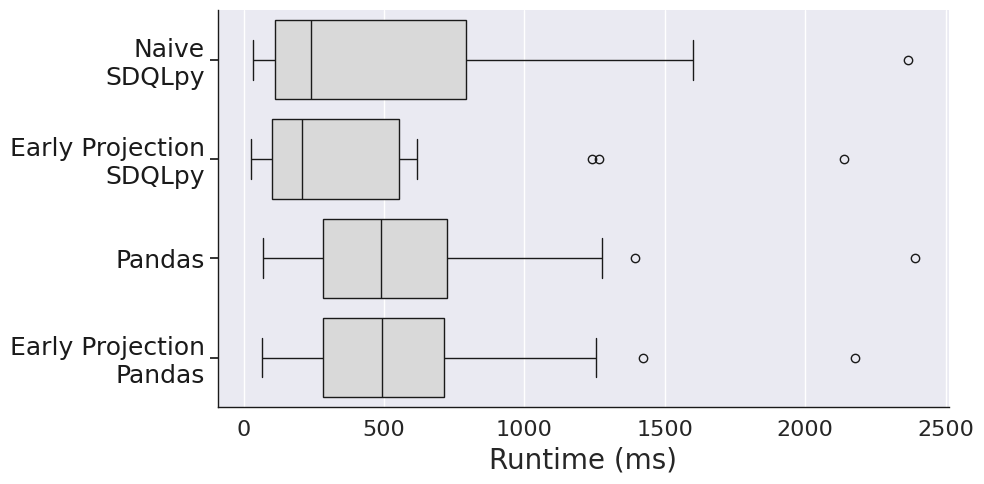

/tmp/ipykernel_88726/2059523897.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Mean'] = new_df['Mean'].apply(lambda x : x * 1000)
/tmp/ipykernel_88726/2059523897.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Query Type'] = new_df['Query Type'].replace(


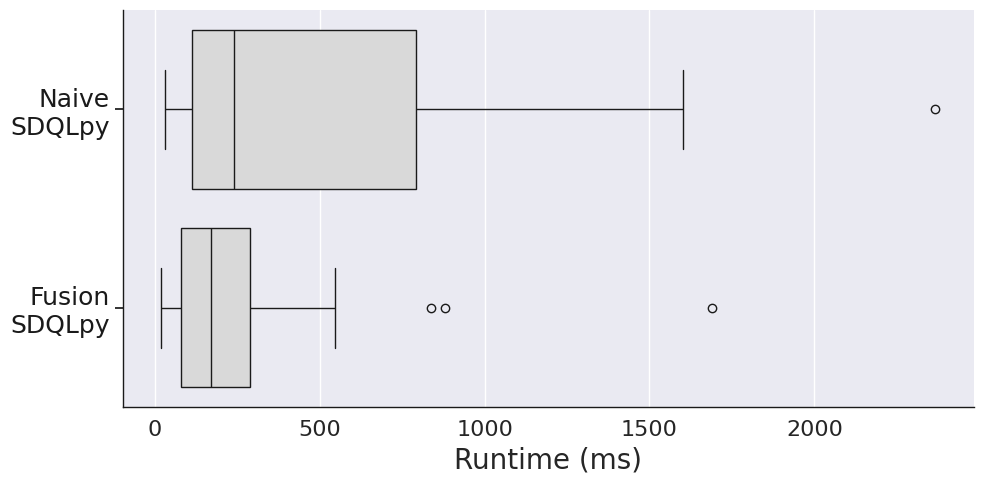

In [670]:
for filename, data_labels in compare_groups:
    make_boxplot_graph(
        results,
        data_labels,
        f"../analysis_results/y2_report/{filename}"
    )

## Dense Hyper Parameter Tuning

In [671]:
dense_results = pd.read_csv("../test_results/hyper_sdqlpy_dense_tuning_test_results.csv") 

print(f"Overall Results: {len(dense_results)}")

# Filter for Correct == True and Executed == Yes
dense_results = dense_results[(dense_results.Correct == True) & (dense_results.Executed == "Yes")]
print(f"Correct Results: {len(dense_results)}")

dense_results = pre_process(dense_results)

Overall Results: 286
Correct Results: 286


In [672]:
# O1 SDQLpy	: 0.155856

dense_overall = make_overall_table(dense_results)
dense_overall.head(15)

,Overall Mean Runtime (s)
Query Type,
O3 (0.4) SDQLpy,0.142164
O3 (0.5) SDQLpy,0.142544
O3 (0.9999) SDQLpy,0.142696
O3 (0.6) SDQLpy,0.142729
O3 (0.3) SDQLpy,0.142804
O3 (0.7) SDQLpy,0.143092
O3 (0.9) SDQLpy,0.144155
O3 (0.8) SDQLpy,0.144403
O3 (0.2) SDQLpy,0.144925


In [673]:
naive_runtime = 0.155856

In [674]:
new_den = dense_overall.reset_index()
new_den = new_den[new_den["Query Type"].str.contains("SDQLpy")]
dense_numbers = list(new_den["Overall Mean Runtime (s)"])
print(min(dense_numbers))
print(f"Best O3: {runtime_reduction(naive_runtime, min(dense_numbers))}")
print(f"Worst O3: {runtime_reduction(naive_runtime, max(dense_numbers))}")

0.14216411992018402
Best O3: 8.784955394605262
Worst O3: -5.908025623569633


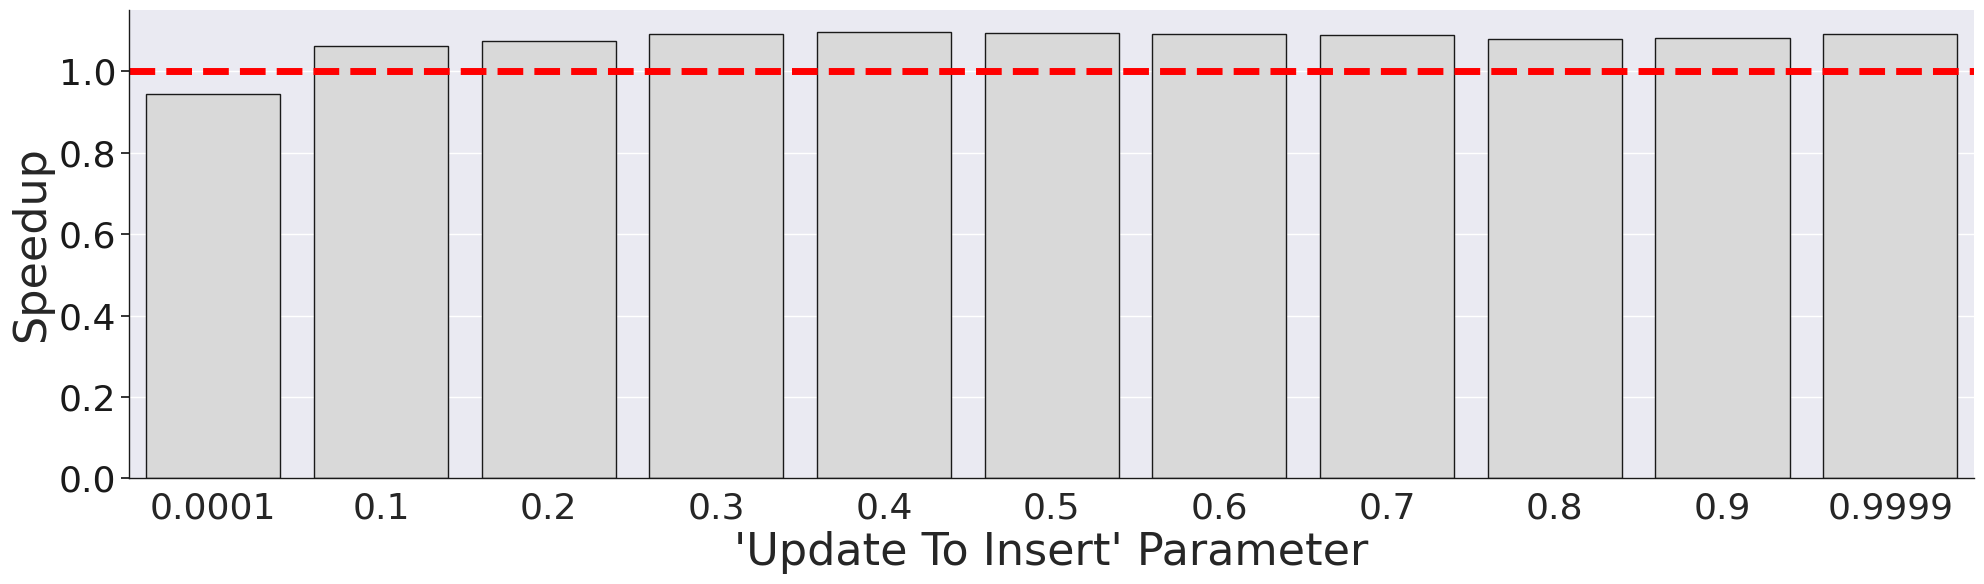

In [675]:
sns.set_theme(rc={'figure.figsize':(20,6)})

plt.rcParams['patch.linewidth'] = 1.0
plt.rcParams['patch.edgecolor'] = 'k'

# Filter results for SDQLpy
filter_dense = dense_overall.reset_index()
filter_dense = filter_dense[filter_dense["Query Type"].str.contains("SDQLpy")]
filter_dense['Overall Mean Runtime (s)'] = filter_dense['Overall Mean Runtime (s)'].apply(lambda x : naive_runtime / x)
filter_dense['Query Type'] = filter_dense['Query Type'].replace(
    {
        "O3 (0.4) SDQLpy": "0.4",
        "O3 (0.5) SDQLpy": "0.5",
        "O3 (0.9999) SDQLpy": "0.9999",
        "O3 (0.0001) SDQLpy": "0.0001",
        "O3 (0.6) SDQLpy": "0.6",
        "O3 (0.3) SDQLpy": "0.3",
        "O3 (0.7) SDQLpy": "0.7",
        "O3 (0.9) SDQLpy": "0.9",
        "O3 (0.8) SDQLpy": "0.8",
        "O3 (0.2) SDQLpy": "0.2",
        "O3 (0.1) SDQLpy": "0.1"
     }
)


# Set order
ax = sns.barplot(data=filter_dense, x="Query Type", y="Overall Mean Runtime (s)", color="#D9D9D9",
                 order=sorted([float(x) for x in list(filter_dense["Query Type"])]))

ax.set_ylabel("Speedup", fontsize=32)
ax.set_xlabel("'Update To Insert' Parameter", fontsize=32)

# Make axes weightier
plt.setp(ax.spines.values(), linewidth=1)

for spine in ax.spines.values():
    spine.set_edgecolor('k')
    

ax.tick_params(axis='x', which='major', labelsize=26)
ax.tick_params(axis='y', which='major', direction="out", colors="k", left=True, labelsize=26)

ax.spines[['right', 'top']].set_visible(False)

ax.axhline(y = 1.0, xmin = 0, xmax = 1,
           color = "red", linestyle = "dashed", linewidth=5)

plt.tight_layout()

filename = f"../analysis_results/y2_report/dense_tuning.pdf"
if filename != None:
    os.makedirs(os.path.dirname(filename), exist_ok=True)  
    plt.savefig(filename, bbox_inches="tight", transparent=True)

plt.show()

### TPC-H Selectivity Histogram

In [676]:
selectivity_data = pd.read_csv("../../tpch_cardinality_tracking.csv")

In [677]:
min(list(selectivity_data["Cardinalities"]))

0.001

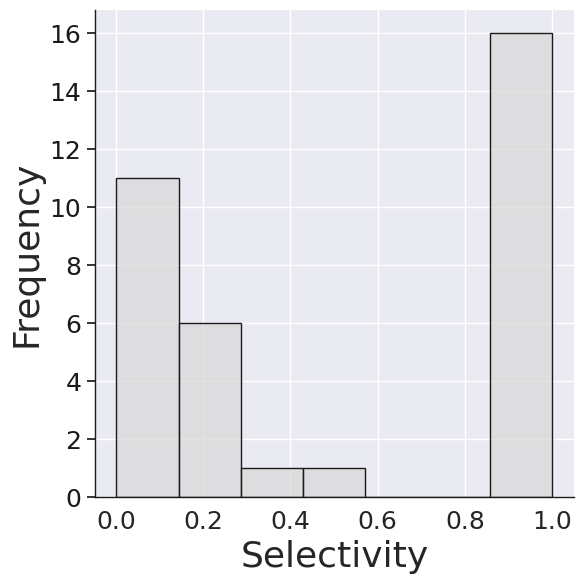

In [678]:
sns.set_theme(rc={'figure.figsize':(6,6)})

plt.rcParams['patch.linewidth'] = 1.0
plt.rcParams['patch.edgecolor'] = 'k'

# Set order
ax = sns.histplot(data=selectivity_data, x="Cardinalities", color="#D9D9D9")

ax.set_ylabel("Frequency", fontsize=26)
ax.set_xlabel("Selectivity", fontsize=26)

# Make axes weightier
plt.setp(ax.spines.values(), linewidth=1)

for spine in ax.spines.values():
    spine.set_edgecolor('k')
    

ax.tick_params(axis='x', which='major', labelsize=18)
ax.tick_params(axis='y', which='major', direction="out", colors="k", left=True, labelsize=18)

ax.spines[['right', 'top']].set_visible(False)


plt.tight_layout()

filename = f"../analysis_results/y2_report/tpch_selectivies.pdf"
if filename != None:
    os.makedirs(os.path.dirname(filename), exist_ok=True)  
    plt.savefig(filename, bbox_inches="tight", transparent=True)

plt.show()